<a href="https://colab.research.google.com/github/yammayamm/image-classification/blob/main/depth_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monocular depth estimation

## Introduction

_Depth estimation_ is a crucial step towards inferring scene geometry from 2D images.
The goal in _monocular depth estimation_ is to predict the depth value of each pixel or
inferring depth information, given only a single RGB image as input.
This example will show an approach to build a depth estimation model with a convnet
and simple loss functions.


## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -qq "/content/drive/MyDrive/AI_challenge_data.zip" # 자신의 train.zip 
#%cd /content/drive/MyDrive/AI_challenge_data/

In [ ]:
import os
import sys

import tensorflow as tf
from tensorflow.keras import layers

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

tf.random.set_seed(123)

##  Preparing the dataset

We only use the indoor images to train our depth estimation model.

In [ ]:
filelist1 = []
filelist2 = []

for root, dirs, files in os.walk("Train/SEM"):
    for file in files:
        filelist1.append(os.path.join(root, file))
filelist1.sort()
for root, dirs, files in os.walk("Validation/SEM"):
    for file in files:
        filelist2.append(os.path.join(root, file))
filelist2.sort()
image = filelist1+filelist2

filelist1 = []
filelist2 = []
for root, dirs, files in os.walk("Train/Depth"):
    for file in files:
        filelist1.extend([os.path.join(root, file)] * 4)
filelist1.sort()
for root, dirs, files in os.walk("Validation/Depth"):
    for file in files:
        filelist2.extend([os.path.join(root, file)] * 4)
filelist2.sort()
depth = filelist1+filelist2

data = {
    "image": [x for x in image if x.endswith(".png")],
    "depth": [x for x in depth if x.endswith(".png")],
#    "mask": [x for x in filelist if x.endswith("_depth_mask.npy")],
}
df = pd.DataFrame(data)

#df = df.sample(frac=1, random_state=42)
df

,image,depth
0,Train/SEM/20201001_202940_NE142400C_RAE01_1_S0...,Train/Depth/20201001_202940_NE142400C_RAE01_1_...
1,Train/SEM/20201001_202940_NE142400C_RAE01_1_S0...,Train/Depth/20201001_202940_NE142400C_RAE01_1_...
2,Train/SEM/20201001_202940_NE142400C_RAE01_1_S0...,Train/Depth/20201001_202940_NE142400C_RAE01_1_...
3,Train/SEM/20201001_202940_NE142400C_RAE01_1_S0...,Train/Depth/20201001_202940_NE142400C_RAE01_1_...
4,Train/SEM/20201001_202940_NE142400C_RAE01_1_S0...,Train/Depth/20201001_202940_NE142400C_RAE01_1_...
...,...,...
47995,Validation/SEM/20210410_095112_NE142400C_RAE10...,Validation/Depth/20210410_095112_NE142400C_RAE...
47996,Validation/SEM/20210410_095112_NE142400C_RAE10...,Validation/Depth/20210410_095112_NE142400C_RAE...
47997,Validation/SEM/20210410_095112_NE142400C_RAE10...,Validation/Depth/20210410_095112_NE142400C_RAE...
47998,Validation/SEM/20210410_095112_NE142400C_RAE10...,Validation/Depth/20210410_095112_NE142400C_RAE...


## Preparing hyperparameters

In [ ]:
HEIGHT = 256
WIDTH = 256
LR = 0.002
EPOCHS = 5
BATCH_SIZE = 64

## Building a data pipeline

1. The pipeline takes a dataframe containing the path for the RGB images,
as well as the depth and depth mask files.
2. It reads and resize the RGB images.
3. It reads the depth and depth mask files, process them to generate the depth map image and
resize it.
4. It returns the RGB images and the depth map images for a batch.

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=4, dim=(256, 256), n_channels=3, shuffle=False):
        """
        Initialization
        """
        self.data = data
        self.indices = self.data.index.tolist()
        self.dim = dim
        self.n_channels = n_channels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.min_depth = 0.1
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        if (index + 1) * self.batch_size > len(self.indices):
            self.batch_size = len(self.indices) - index * self.batch_size
        # Generate one batch of data
        # Generate indices of the batch
        index = self.indices[index * self.batch_size : (index + 1) * self.batch_size]
        # Find list of IDs
        batch = [self.indices[k] for k in index]
        x, y = self.data_generation(batch)

        return x, y

    def on_epoch_end(self):

        """
        Updates indexes after each epoch
        """
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def load(self, image_path, depth_map):
        """Load input and target image."""

        image_ = cv2.imread(image_path)
        image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)
        image_ = cv2.resize(image_, self.dim)
        image_ = tf.image.convert_image_dtype(image_, tf.float32)

        depth_map = cv2.imread(depth_map, 0) # grayscale
#        depth_map = imageio.imread(depth_map)
#        max_depth = min(300, np.percentile(depth_map, 99))
#        depth_map = np.clip(depth_map, self.min_depth, max_depth)

#        depth_map = np.clip(depth_map, 0.1, np.log(max_depth))
        depth_map = cv2.resize(depth_map, self.dim)
        depth_map = np.expand_dims(depth_map, axis=2)
        depth_map = tf.image.convert_image_dtype(depth_map, tf.float32)

        return image_, depth_map

    def data_generation(self, batch):

        x = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, 1))
        
        for i, batch_id in enumerate(batch):
            x[i,], y[i,] = self.load(
                self.data["image"][batch_id],
                self.data["depth"][batch_id],
            )

        return x, y


## Visualizing samples

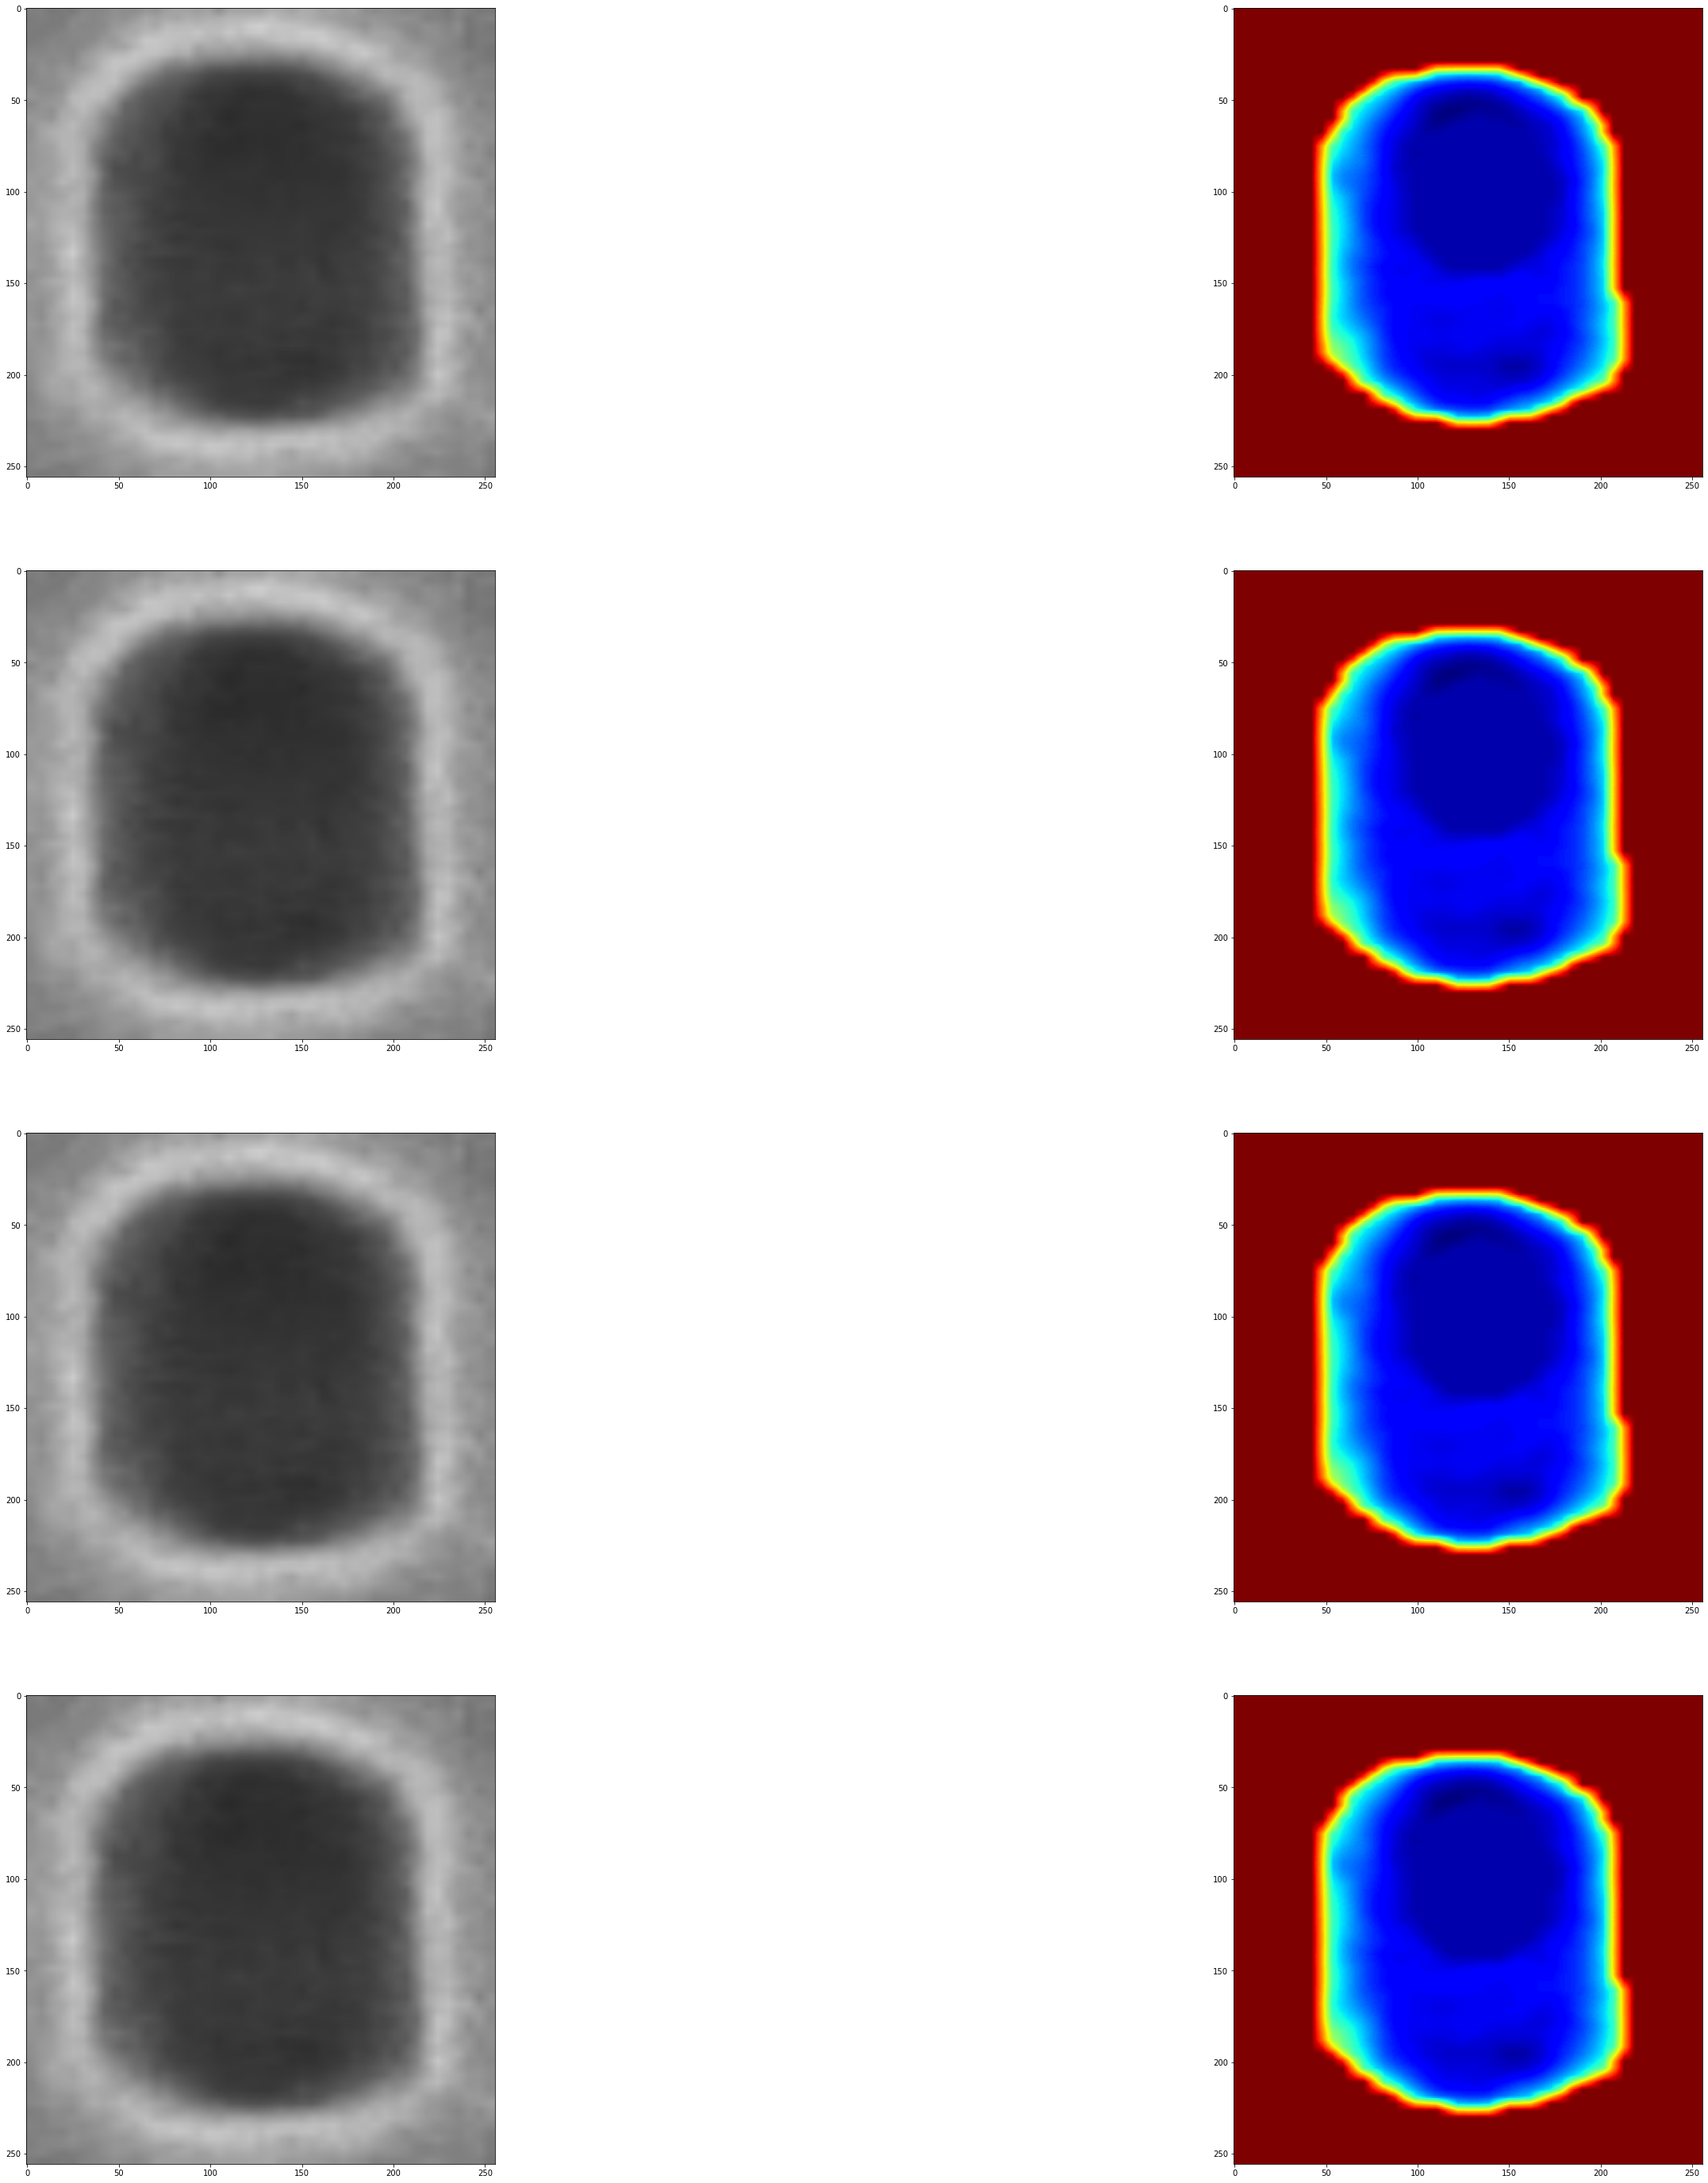

In [ ]:
def visualize_depth_map(samples, test=False, model=None):
    input, target = samples
    cmap = plt.cm.jet
    cmap.set_bad(color="black")

    if test:
        pred = model.predict(input)
        fig, ax = plt.subplots(6, 3, figsize=(50, 50))
        for i in range(6):
            ax[i, 0].imshow((input[i].squeeze()))
            ax[i, 1].imshow((target[i].squeeze()), cmap=cmap)
            ax[i, 2].imshow((pred[i].squeeze()), cmap=cmap)

    else:
        fig, ax = plt.subplots(4, 2, figsize=(50, 50))
        for i in range(4):
            ax[i, 0].imshow((input[i].squeeze()))
            ax[i, 1].imshow((target[i].squeeze()), cmap=cmap)


visualize_samples = next(
    iter(DataGenerator(data=df, batch_size=4, dim=(HEIGHT, WIDTH)))
)
visualize_depth_map(visualize_samples)

## 3D point cloud visualization

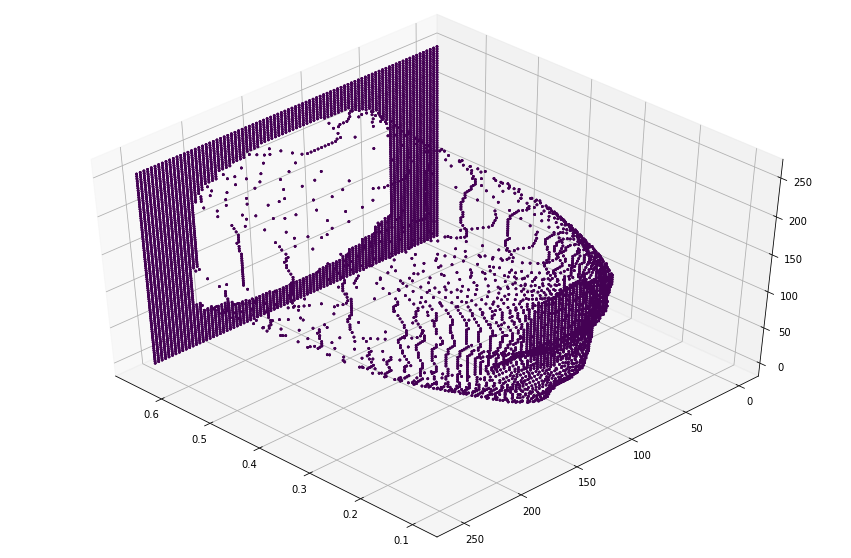

In [ ]:
depth_vis = np.flipud(visualize_samples[1][1].squeeze())  # target
img_vis = np.flipud(visualize_samples[0][1].squeeze())  # input

fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection="3d")

STEP = 3
for x in range(0, img_vis.shape[0], STEP):
    for y in range(0, img_vis.shape[1], STEP):
        ax.scatter(
            [depth_vis[x, y]] * 3,
            [y] * 3,
            [x] * 3,
            c=tuple(img_vis[x, y, :3] / 255),
            s=3,
        )
    ax.view_init(45, 135)

## Building the model

1. The basic model is from U-Net.
2. Addditive skip-connections are implemented in the downscaling block.

In [ ]:

class DownscaleBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)
        self.bn2a = tf.keras.layers.BatchNormalization()
        self.bn2b = tf.keras.layers.BatchNormalization()

        self.pool = layers.MaxPool2D((2, 2), (2, 2))

    def call(self, input_tensor):
        d = self.convA(input_tensor)
        x = self.bn2a(d)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.reluB(x)

        x += d
        p = self.pool(x)
        return x, p


class UpscaleBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.us = layers.UpSampling2D((2, 2))
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)
        self.bn2a = tf.keras.layers.BatchNormalization()
        self.bn2b = tf.keras.layers.BatchNormalization()
        self.conc = layers.Concatenate()

    def call(self, x, skip):
        x = self.us(x)
        concat = self.conc([x, skip])
        x = self.convA(concat)
        x = self.bn2a(x)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.reluB(x)

        return x


class BottleNeckBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)

    def call(self, x):
        x = self.convA(x)
        x = self.reluA(x)
        x = self.convB(x)
        x = self.reluB(x)
        return x


## Defining the loss

We will optimize 3 losses in our mode.
1. Structural similarity index(SSIM).
2. L1-loss, or Point-wise depth in our case.
3. Depth smoothness loss.

Out of the three loss functions, SSIM contributes the most to improving model performance.

In [ ]:
class DepthEstimationModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.ssim_loss_weight = 0.85
        self.l1_loss_weight = 0.1
        self.edge_loss_weight = 0.9
        self.loss_metric = tf.keras.metrics.Mean(name="loss")
        f = [16, 32, 64, 128, 256]
        self.downscale_blocks = [
            DownscaleBlock(f[0]),
            DownscaleBlock(f[1]),
            DownscaleBlock(f[2]),
            DownscaleBlock(f[3]),
        ]
        self.bottle_neck_block = BottleNeckBlock(f[4])
        self.upscale_blocks = [
            UpscaleBlock(f[3]),
            UpscaleBlock(f[2]),
            UpscaleBlock(f[1]),
            UpscaleBlock(f[0]),
        ]
        self.conv_layer = layers.Conv2D(1, (1, 1), padding="same", activation="tanh")

    def calculate_loss(self, target, pred):
        # Edges
        dy_true, dx_true = tf.image.image_gradients(target)
        dy_pred, dx_pred = tf.image.image_gradients(pred)
        weights_x = tf.exp(tf.reduce_mean(tf.abs(dx_true)))
        weights_y = tf.exp(tf.reduce_mean(tf.abs(dy_true)))

        # Depth smoothness
        smoothness_x = dx_pred * weights_x
        smoothness_y = dy_pred * weights_y

        depth_smoothness_loss = tf.reduce_mean(abs(smoothness_x)) + tf.reduce_mean(
            abs(smoothness_y)
        )

        # Structural similarity (SSIM) index
        ssim_loss = tf.reduce_mean(
            1
            - tf.image.ssim(
                target, pred, max_val=WIDTH, filter_size=7, k1=0.01 ** 2, k2=0.03 ** 2
            )
        )
        # Point-wise depth
        l1_loss = tf.reduce_mean(tf.abs(target - pred))

        # RMSE
        #diff = tf.math.multiply(pred - target, mask) / 1000.0    # mapping the distance from millimeters to meters

        loss_mse = tf.reduce_sum(tf.pow(diff, 2)) / num_pixels
        loss_rmse = tf.sqrt(loss_mse)

#        loss = (
#            (self.ssim_loss_weight * ssim_loss)
#            + (self.l1_loss_weight * l1_loss)
#            + (self.edge_loss_weight * depth_smoothness_loss)
#        )

        return loss_rmse

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch_data):
        input, target = batch_data
        with tf.GradientTape() as tape:
            pred = self(input, training=True)
            #loss = self.calculate_loss(target, pred)
            loss = tf.sqrt(tf.reduce_mean((target - pred)**2))

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.loss_metric.update_state(loss)
        return {
            "loss": self.loss_metric.result(),
        }

    def test_step(self, batch_data):
        input, target = batch_data

        pred = self(input, training=False)
        #loss = self.calculate_loss(target, pred)
        loss = tf.sqrt(tf.reduce_mean((target - pred)**2))

        self.loss_metric.update_state(loss)
        return {
            "loss": self.loss_metric.result(),
        }

    def call(self, x):
        c1, p1 = self.downscale_blocks[0](x)
        c2, p2 = self.downscale_blocks[1](p1)
        c3, p3 = self.downscale_blocks[2](p2)
        c4, p4 = self.downscale_blocks[3](p3)

        bn = self.bottle_neck_block(p4)

        u1 = self.upscale_blocks[0](bn, c4)
        u2 = self.upscale_blocks[1](u1, c3)
        u3 = self.upscale_blocks[2](u2, c2)
        u4 = self.upscale_blocks[3](u3, c1)

        return self.conv_layer(u4)


## Model training

In [ ]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LR,
    amsgrad=False,
)
model = DepthEstimationModel()
# Define the loss function
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)
# Compile the model
model.compile(optimizer, loss=cross_entropy)

train_loader = DataGenerator(
    data=df[:40000].reset_index(drop="true"), batch_size=BATCH_SIZE, dim=(HEIGHT, WIDTH)
)
validation_loader = DataGenerator(
    data=df[40000:].reset_index(drop="true"), batch_size=BATCH_SIZE, dim=(HEIGHT, WIDTH)
)
hist = model.fit(
    train_loader,
    epochs=EPOCHS,
    validation_data=validation_loader,
)

Epoch 1/5
625/625 [==============================] - 585s 926ms/step - loss: 0.0475 - val_loss: 0.0389
Epoch 2/5
625/625 [==============================] - 582s 931ms/step - loss: 0.0166 - val_loss: 0.0176
Epoch 3/5
625/625 [==============================] - 581s 929ms/step - loss: 0.0159 - val_loss: 0.0203
Epoch 4/5
625/625 [==============================] - 581s 929ms/step - loss: 0.0150 - val_loss: 0.0176
Epoch 5/5
625/625 [==============================] - 581s 930ms/step - loss: 0.0147 - val_loss: 0.0148


{'loss': [0.0475209578871727, 0.016608966514468193, 0.015878643840551376, 0.01503642275929451, 0.014706593006849289], 'val_loss': [0.03887685760855675, 0.01759113371372223, 0.02025166153907776, 0.017609288915991783, 0.014848005026578903]}


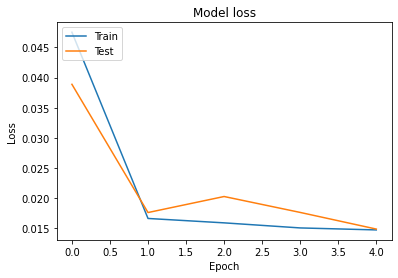

In [ ]:
print(hist.history)


# 7 훈련 과정 시각화 (손실)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model.save('AI_model')

In [ ]:
model.save('/content/drive/MyDrive/AI_model')

In [ ]:
reconstructed_model = tf.keras.models.load_model("/content/drive/MyDrive/AI_model")

In [ ]:
reconstructed_model.fit(train_loader,
    epochs=EPOCHS,
    validation_data=validation_loader,)

## Visualizing model output

We visualize the model output over the validation set.
The first image is the RGB image, the second image is the ground truth depth map image
and the third one is the predicted depth map image.

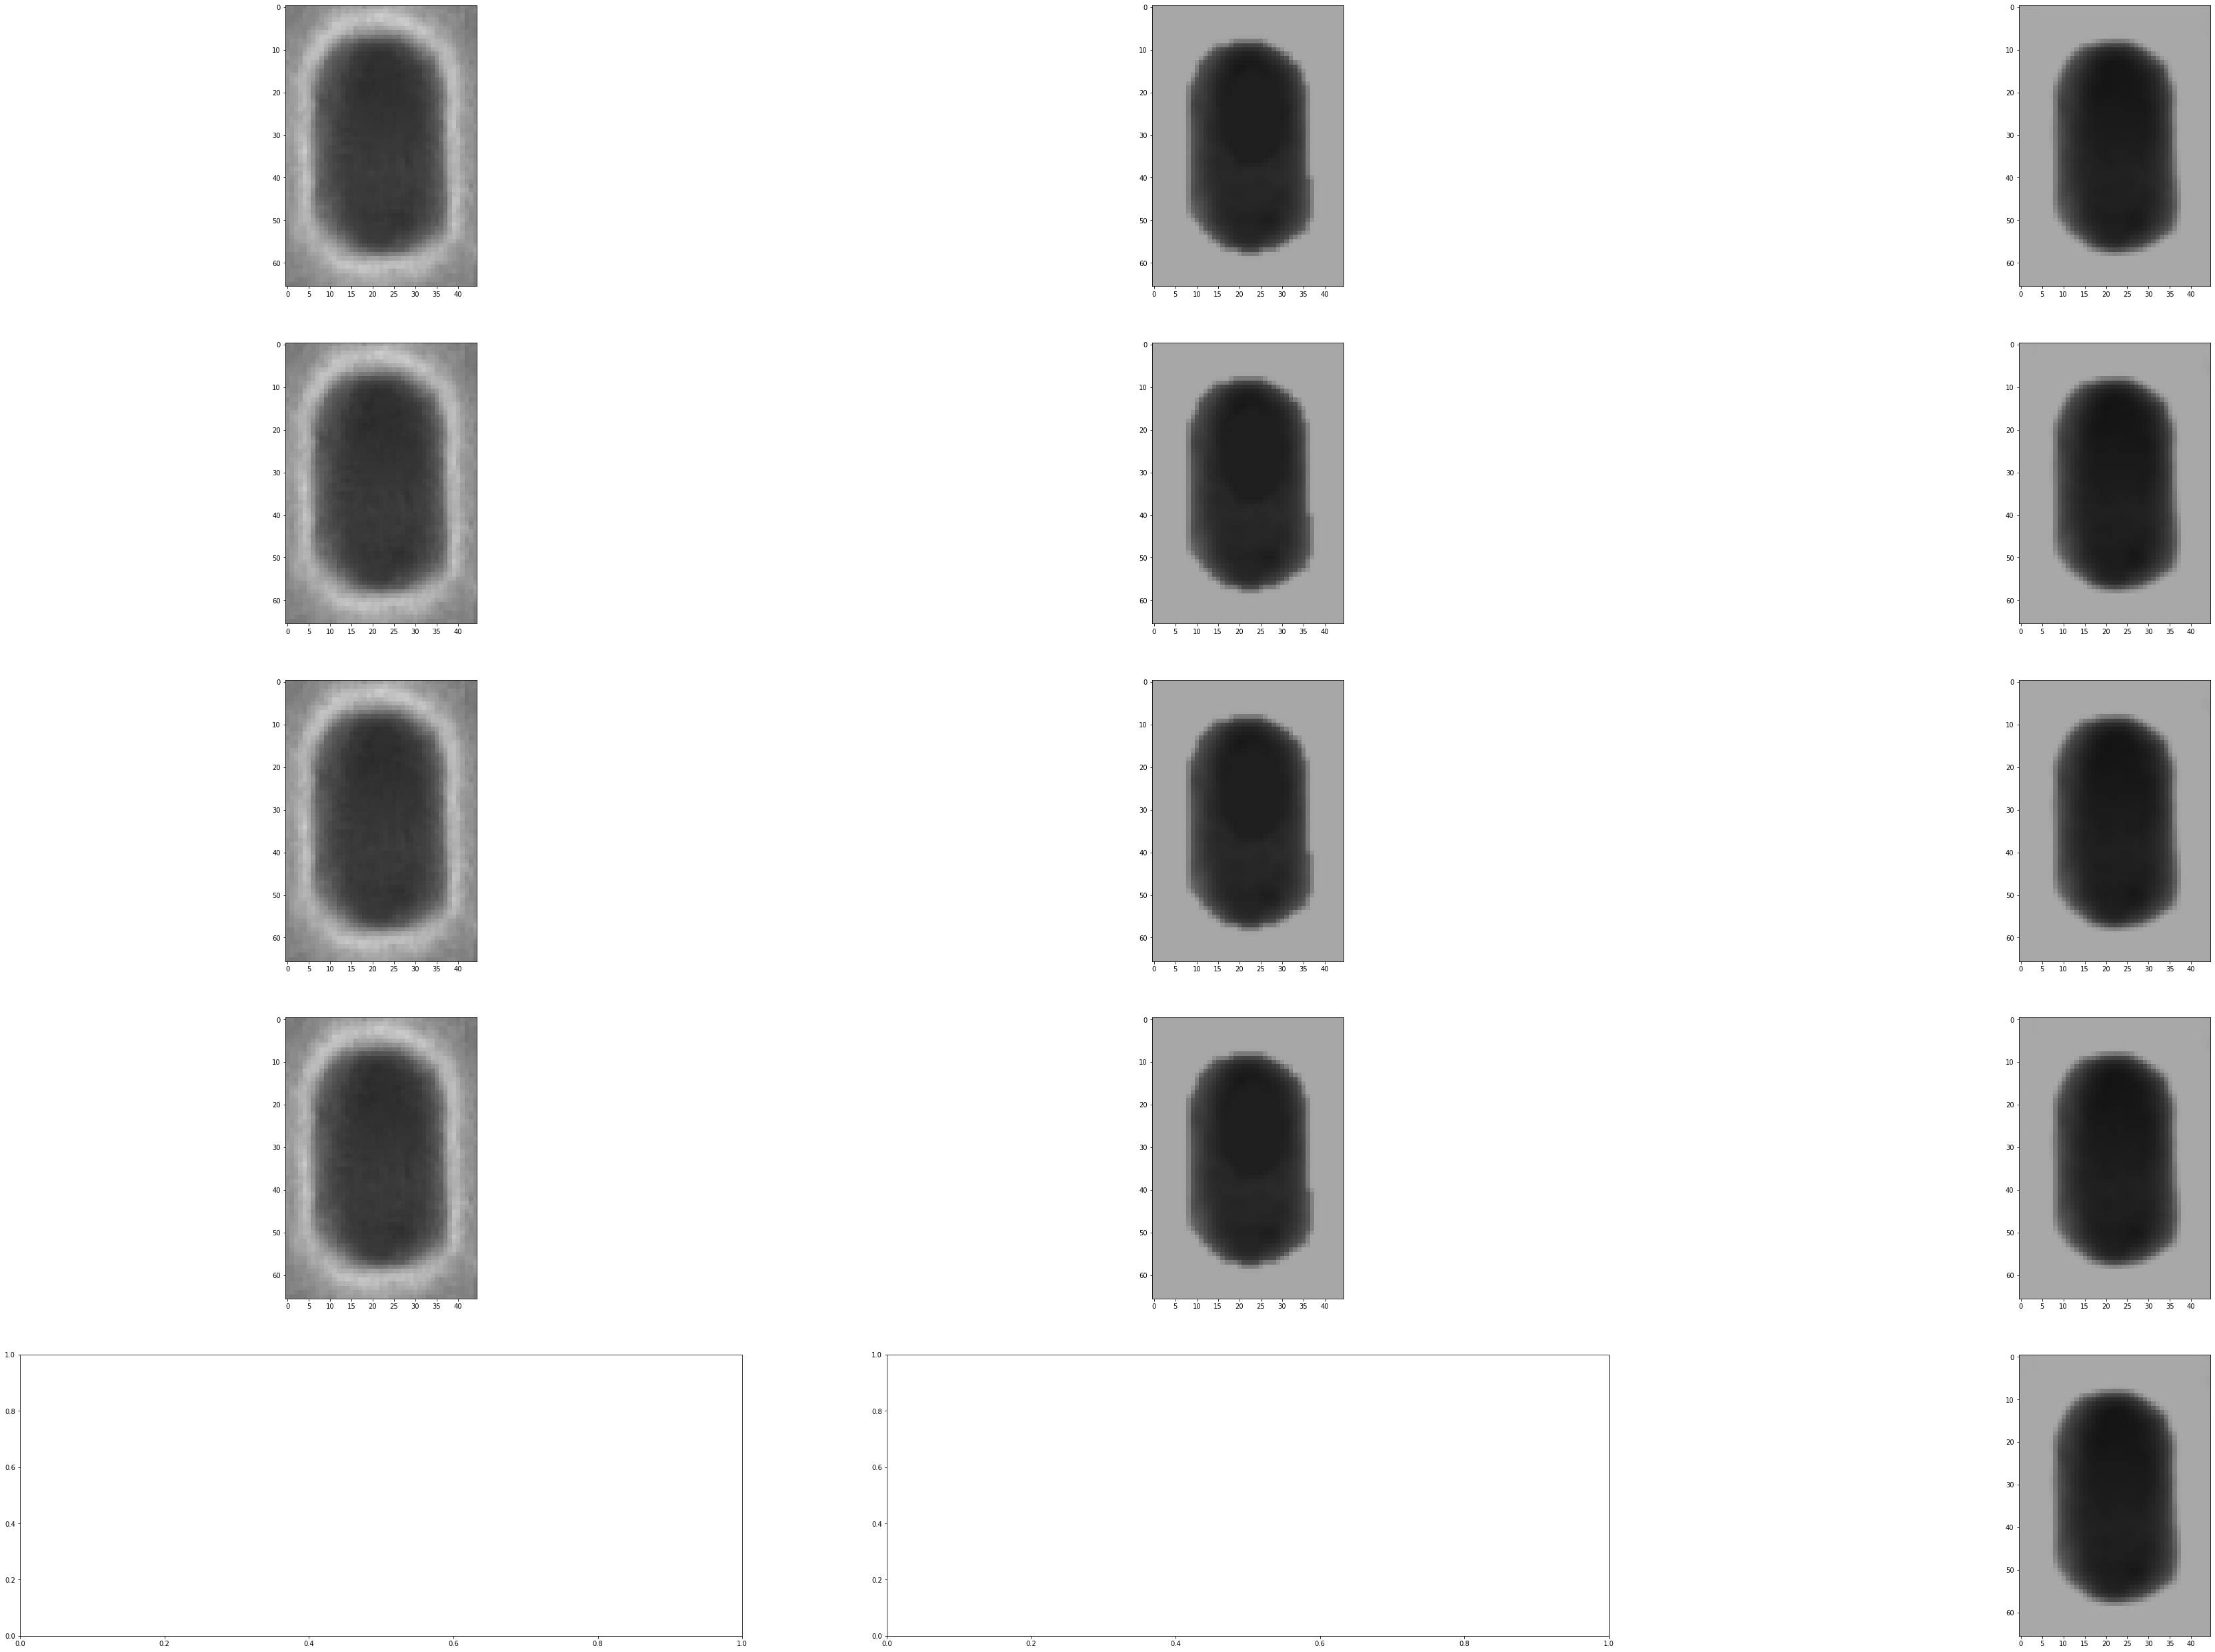

In [ ]:
def visualize_depth_map(samples, test=False, model=None):
    input, target = samples
    cmap = plt.cm.jet
    cmap.set_bad(color="black")

    if test:
        pred = model.predict(input)
        fig, ax = plt.subplots(5, 3, figsize=(66, 45))
        for i in range(4):
            ax[i, 0].imshow((cv2.resize(input[i].squeeze(), (45, 66))))
            ax[i, 1].imshow((cv2.resize(np.repeat(target[i], 3, axis=-1).squeeze(), (45,66))), cmap=cmap)
            ax[i, 2].imshow((cv2.resize(np.repeat(pred[i], 3, axis=-1).squeeze(), (45,66))), cmap=cmap)
        pred_mean = np.mean(pred, axis=0)
        ax[4, 2].imshow((cv2.resize(np.repeat(pred_mean, 3, axis=-1).squeeze(), (45,66))), cmap=cmap)
    else:
        fig, ax = plt.subplots(4, 2, figsize=(66, 45))
        for i in range(4):
            ax[i, 0].imshow((input[i].squeeze()))
            ax[i, 1].imshow((target[i].squeeze()), cmap=cmap)

test_loader = next(
    iter(
        DataGenerator(
            data=df[:5].reset_index(drop="true"), batch_size=4, dim=(HEIGHT, WIDTH)
        )
    )
)
visualize_depth_map(test_loader, test=True, model=model)

In [ ]:
filelist = []
for root, dirs, files in os.walk("Test/SEM"):
    for file in files:
        filelist.append(os.path.join(root, file))
filelist.sort()

data = {
    "image": [x for x in filelist if x.endswith(".png")],
    "depth": [x for x in filelist if x.endswith(".png")],
#    "mask": [x for x in filelist if x.endswith("_depth_mask.npy")],
}
testdf = pd.DataFrame(data)

#df = df.sample(frac=1, random_state=42)
testdf

,image,depth
0,Test/SEM/20210304_165053_NE142400C_RAA26_1_S01...,Test/SEM/20210304_165053_NE142400C_RAA26_1_S01...
1,Test/SEM/20210304_165053_NE142400C_RAA26_1_S01...,Test/SEM/20210304_165053_NE142400C_RAA26_1_S01...
2,Test/SEM/20210304_165053_NE142400C_RAA26_1_S01...,Test/SEM/20210304_165053_NE142400C_RAA26_1_S01...
3,Test/SEM/20210304_165053_NE142400C_RAA26_1_S01...,Test/SEM/20210304_165053_NE142400C_RAA26_1_S01...
4,Test/SEM/20210304_165053_NE142400C_RAA26_1_S01...,Test/SEM/20210304_165053_NE142400C_RAA26_1_S01...
...,...,...
4995,Test/SEM/20210410_095112_NE142400C_RAE10_1_S03...,Test/SEM/20210410_095112_NE142400C_RAE10_1_S03...
4996,Test/SEM/20210410_095112_NE142400C_RAE10_1_S03...,Test/SEM/20210410_095112_NE142400C_RAE10_1_S03...
4997,Test/SEM/20210410_095112_NE142400C_RAE10_1_S03...,Test/SEM/20210410_095112_NE142400C_RAE10_1_S03...
4998,Test/SEM/20210410_095112_NE142400C_RAE10_1_S03...,Test/SEM/20210410_095112_NE142400C_RAE10_1_S03...


In [ ]:
testdf['image'][0].split('/')[-1][:-8]

In [ ]:
from PIL import Image

cmap = plt.cm.jet
cmap.set_bad(color="black")

testdepth = []

for i in range(1250):
    test_loader2 = next(
        iter(
            DataGenerator(
                data=testdf[4*i:].reset_index(drop="true"), batch_size=4, dim=(HEIGHT, WIDTH)
            )
        )
    )

    input, target = test_loader2

    pred = model.predict(input)

    for i in range(4):
        pred_ = np.delete(cv2.resize(pred[i].squeeze(), (45,66)), (0,1), axis=-1).squeeze()
        testdepth.append((pred_*255).astype('uint8'))

In [ ]:
for i in range(len(testdepth)):
  temp = testdf['image'][i].split('/')[-1][:-8]
  for j in range(4):
    cv2.imwrite(f'/content/drive/MyDrive/AI_challenge_data/Test/Depth/{temp}itr{j}.png', testdepth[i])

#!/usr/bin/python
from PIL import Image
import os, sys

path = "/content/drive/MyDrive/AI_challenge_data/Test/Depth/"
dirs = os.listdir( path )

def resize():
    for item in dirs:
        if os.path.isfile(path+item):
            im = Image.open(path+item)
            f, e = os.path.splitext(path+item)
            imResize = im.resize((45,66), Image.ANTIALIAS)
            imResize.save(f'/content/drive/MyDrive/AI_challenge_data/Depth/{item}')

resize()